In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
import pickle
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [3]:
ResNet50_MODEL=tf.keras.applications.ResNet50(input_shape=(224,224,3),
                                               include_top=False,
                                               weights="imagenet")

In [4]:
len(ResNet50_MODEL.layers)

175

In [5]:
ResNet50_MODEL.layers[15].name

'conv2_block1_0_bn'

In [6]:
for layer in ResNet50_MODEL.layers:
    layer.trainable=True

In [7]:
ResNet50_MODEL.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [8]:
batch_size = 64
l1_factor = 0.0001
l2_factor = 0.001
dropout = 0.5
learning_rate = 0.0001
target_size_image_shape = (224, 224)

In [9]:
model=tf.keras.models.Sequential([
                                  ResNet50_MODEL,
                                  tf.keras.layers.GlobalAveragePooling2D(),
                                  tf.keras.layers.Dropout(dropout, name='Dropout_Regularization1'),
                                  tf.keras.layers.Dense(4040, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
Dropout_Regularization1 (Dro (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4040)              8277960   
Total params: 31,865,672
Trainable params: 31,812,552
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
train_data_dir = '../datasets/group11_set_224/set_224/train/'
valid_data_dir = '../datasets/group11_set_224/set_224/valid/'

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1.0/255)

In [12]:
#flow training images
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 323131 images belonging to 4040 classes.


In [13]:
valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 80800 images belonging to 4040 classes.


In [14]:
outputFolder = 'checkpoints'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"/model-{epoch:02d}-{val_acc:.2f}.hdf5"

In [15]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_acc', verbose=1, mode='max',
    save_best_only=True, save_weights_only=False,
    save_frequency='epoch')

In [16]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=1, write_graph=True, write_images=True,
    update_freq='epoch', profile_batch=2, embeddings_freq=1,
    embeddings_metadata=None
)

In [17]:
history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch = train_generator.n // batch_size,
    validation_data = valid_generator,
    validation_steps = valid_generator.n // batch_size,
    callbacks=[checkpoint_callback, tensorboard_callback],
    epochs = 100,
    workers = 8,
    verbose=1
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
5048/5048 [==============================] - ETA: 0s - loss: 6.4249 - acc: 0.0746
Epoch 00001: val_acc improved from -inf to 0.24037, saving model to checkpoints/model-01-0.24.hdf5
5048/5048 [==============================] - 1583s 314ms/step - loss: 6.4249 - acc: 0.0746 - val_loss: 4.4448 - val_acc: 0.2404
Epoch 2/100
5048/5048 [==============================] - ETA: 0s - loss: 4.2598 - acc: 0.2554
Epoch 00002: val_acc improved from 0.24037 to 0.34421, saving model to checkpoints/model-02-0.34.hdf5
5048/5048 [==============================] - 1584s 314ms/step - loss: 4.2598 - acc: 0.2554 - val_loss: 3.7194 - val_acc: 0.3442
Epoch 3/100
5048/5048 [==============================] - ETA: 0s - loss: 3.5334 - acc: 0.3498
Epoch 00003: val_acc improved from 0.34421 to 0.41134, saving model to checkpoints/model-03-0.41.hdf5
5048/5048 [==============================] - 1583s 314ms/step - loss: 3.5334 - acc:

5048/5048 [==============================] - ETA: 0s - loss: 0.7523 - acc: 0.8021
Epoch 00027: val_acc did not improve from 0.58591
5048/5048 [==============================] - 1575s 312ms/step - loss: 0.7523 - acc: 0.8021 - val_loss: 2.9174 - val_acc: 0.5749
Epoch 28/100
5048/5048 [==============================] - ETA: 0s - loss: 0.7222 - acc: 0.8087
Epoch 00028: val_acc did not improve from 0.58591
5048/5048 [==============================] - 1584s 314ms/step - loss: 0.7222 - acc: 0.8087 - val_loss: 2.7977 - val_acc: 0.5772
Epoch 29/100
5048/5048 [==============================] - ETA: 0s - loss: 0.6963 - acc: 0.8149
Epoch 00029: val_acc did not improve from 0.58591
5048/5048 [==============================] - 1586s 314ms/step - loss: 0.6963 - acc: 0.8149 - val_loss: 2.8460 - val_acc: 0.5699
Epoch 30/100
5048/5048 [==============================] - ETA: 0s - loss: 0.6649 - acc: 0.8219
Epoch 00030: val_acc did not improve from 0.58591
5048/5048 [==============================] - 1576

Epoch 57/100
5048/5048 [==============================] - ETA: 0s - loss: 0.3076 - acc: 0.9108
Epoch 00057: val_acc did not improve from 0.60946
5048/5048 [==============================] - 1587s 314ms/step - loss: 0.3076 - acc: 0.9108 - val_loss: 3.6127 - val_acc: 0.5774
Epoch 58/100
5048/5048 [==============================] - ETA: 0s - loss: 0.3015 - acc: 0.9120
Epoch 00058: val_acc did not improve from 0.60946
5048/5048 [==============================] - 1579s 313ms/step - loss: 0.3015 - acc: 0.9120 - val_loss: 3.7877 - val_acc: 0.5727
Epoch 59/100
5048/5048 [==============================] - ETA: 0s - loss: 0.2954 - acc: 0.9139
Epoch 00059: val_acc did not improve from 0.60946
5048/5048 [==============================] - 1580s 313ms/step - loss: 0.2954 - acc: 0.9139 - val_loss: 3.4116 - val_acc: 0.5897
Epoch 60/100
5048/5048 [==============================] - ETA: 0s - loss: 0.2877 - acc: 0.9166
Epoch 00060: val_acc did not improve from 0.60946
5048/5048 [=========================

Epoch 87/100
5048/5048 [==============================] - ETA: 0s - loss: 0.1937 - acc: 0.9428
Epoch 00087: val_acc did not improve from 0.61088
5048/5048 [==============================] - 1581s 313ms/step - loss: 0.1937 - acc: 0.9428 - val_loss: 3.7903 - val_acc: 0.5819
Epoch 88/100
5048/5048 [==============================] - ETA: 0s - loss: 0.1913 - acc: 0.9434
Epoch 00088: val_acc did not improve from 0.61088
5048/5048 [==============================] - 1582s 313ms/step - loss: 0.1913 - acc: 0.9434 - val_loss: 3.9202 - val_acc: 0.5979
Epoch 89/100
5048/5048 [==============================] - ETA: 0s - loss: 0.1892 - acc: 0.9442
Epoch 00089: val_acc did not improve from 0.61088
5048/5048 [==============================] - 1582s 313ms/step - loss: 0.1892 - acc: 0.9442 - val_loss: 4.1572 - val_acc: 0.5781
Epoch 90/100
5048/5048 [==============================] - ETA: 0s - loss: 0.1879 - acc: 0.9446
Epoch 00090: val_acc did not improve from 0.61088
5048/5048 [=========================

In [ ]:
sfsdfsdsdfs

In [18]:
tf.keras.models.save_model(history.model, 'group11_set224_resnet50_07202020.hdf5', include_optimizer=False)

<Figure size 432x288 with 0 Axes>

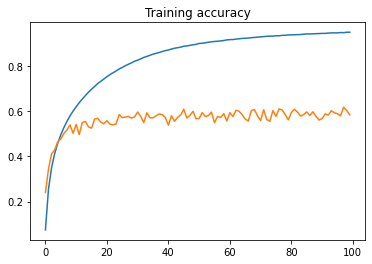

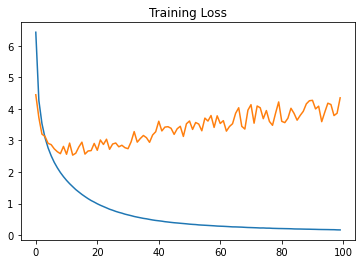

<Figure size 432x288 with 0 Axes>

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training Loss')
plt.figure()

In [ ]:
gsedrfgdffg

### Predict Image

In [20]:
indices_to_class_labels_dict = {value : key for key, value in train_generator.class_indices.items()}

In [21]:
print(len(indices_to_class_labels_dict))
print(indices_to_class_labels_dict)

4040
{0: '100028', 1: '100082', 2: '100192', 3: '100230', 4: '100372', 5: '100407', 6: '100484', 7: '100505', 8: '100533', 9: '100614', 10: '100631', 11: '100674', 12: '100740', 13: '100826', 14: '100895', 15: '10090', 16: '100951', 17: '100955', 18: '100966', 19: '100982', 20: '101043', 21: '101056', 22: '101112', 23: '101128', 24: '101138', 25: '101176', 26: '101241', 27: '101271', 28: '101318', 29: '101339', 30: '101399', 31: '101400', 32: '101457', 33: '101708', 34: '101727', 35: '101857', 36: '101881', 37: '101940', 38: '101946', 39: '102002', 40: '102108', 41: '102146', 42: '102154', 43: '10217', 44: '102178', 45: '102206', 46: '102320', 47: '102329', 48: '102375', 49: '102402', 50: '102416', 51: '10248', 52: '102488', 53: '102511', 54: '102544', 55: '102554', 56: '102566', 57: '102572', 58: '102598', 59: '102621', 60: '102664', 61: '102680', 62: '102709', 63: '102712', 64: '102850', 65: '102904', 66: '102917', 67: '102942', 68: '102943', 69: '102984', 70: '103049', 71: '103082',

In [22]:
with open("group11_indices_to_class_labels_dict.json", "wb") as pickle_file:
    pickle.dump(indices_to_class_labels_dict, pickle_file)

In [2]:
def resize_image(path, new_width, new_height):
    image = Image.open(path)
    image = ImageOps.fit(image, (new_width, new_height), Image.ANTIALIAS)
    return image

In [3]:
image = resize_image("test_images\\e0dc68db51a90c10.jpg", 224, 224)
image

NameError: name 'Image' is not defined

In [ ]:
np_image = np.array(image)
print(np_image.shape)
np_image = np_image/255
image = np.expand_dims(np_image, axis=0)
result = history.model.predict(image)
predicted_class = indices_to_class_labels_dict[np.argmax(result)]
print("Identified landmark for image is : {}".format(predicted_class))

In [ ]:
history.model.predict(image)

In [ ]:
print(result.sum())